# Running Zest on Clickbait datasets

This notebook shows some of our text preprocessing and entropy calculations before running Zest on this clickbait dataset found on Kaggle.

Dataset link: https://www.kaggle.com/amananandrai/clickbait-dataset?select=clickbait_data.csv

## Load data and preprocess

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import sys
import time
  
# adding Zest classes to the system path
sys.path.insert(0, '../zest')

from collections import Counter
from preprocess_utils import StringNormalizer, CharCounter, WordCounter, cleanup_str, cleanup_corpus
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.pairwise import cosine_similarity
from zest import Zstd2Classifier

In [2]:
df = pd.read_csv('clickbait_data.csv')
df

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [3]:
cb_pos = df[df.clickbait == 1].headline.values
cb_neg = df[df.clickbait == 0].headline.values

In [4]:
char_ctr = CharCounter(list(cb_pos) + list(cb_neg), name='clickbait')
print(char_ctr.remove_bad_chars("ABCD 123 абвгд ,.s-2?ad[]s"))

Found 111 different characters (words, punctuation, blanks), not including emojis
68 good characters:   eoasirntluhdcgmyTASpfWCkvwbBIPFMHYODRLG1NE2U,Kx0JVz5.3798:6j4qQZ;?X
43 leftover characters:  /#+|!*öäłéčßáíúžćîÍºæçñãüśóøÁÜàåșŠšęŚīèūÉńÎ
ABCD 123 ,.s2?ads


In [5]:
examples = ["Hello world", "Click here for 20,000 free coins", "", "Здрасте"]
[char_ctr.compute_cross_entropy(s) for s in examples]

[3.347972948615627, 3.59336707401504, 0.0, 10.239095832916432]

In [6]:
sn = StringNormalizer(no_punct=True)
examples = ["OMG!! 42: What does this mean? (nothing really) 'bla bla bla'...",
            "А это будет работать? #324,232090",
            "20160904_130443_001.jpg",
            "500 FREE Coins to the first 5 clickers!"
            "You scored 73%! WELL DONE",
            "¡Tremendo anillo! Así le pidieron matrimonio a Paris Hilton "]
[sn.normalize_str(s) for s in examples]

['OMG ## What does this mean nothing really bla bla bla',
 'А это будет работать ###',
 '### jpg',
 '### FREE Coins to the first ## clickers You scored ## WELL DONE',
 'Tremendo anillo Así le pidieron matrimonio a Paris Hilton']

## Evaluate Zest

In [7]:
MIN_CHARS = 20
MIN_WORDS = 6

def split_by_wc(titles: list, min_chars: int, min_words: int, sn, char_ctr = None):
    longer_titles = []
    shorter_titles = []
    for t in titles:
        t1 = t if char_ctr is None else char_ctr.remove_bad_chars(t)
        if len(t1) >= min_chars and sn.get_word_count(t1) >= min_words:
            longer_titles.append(t1)
        else:
            shorter_titles.append(t1)
    return np.array(longer_titles), np.array(shorter_titles)

cb_pos_longer, cb_pos_shorter = split_by_wc(cb_pos, MIN_CHARS, MIN_WORDS, sn, char_ctr)
cb_neg_longer, cb_neg_shorter = split_by_wc(cb_neg, MIN_CHARS, MIN_WORDS, sn, char_ctr)

len_p = len(cb_pos)
len_n = len(cb_neg)
len_pl = len(cb_pos_longer)
len_nl = len(cb_neg_longer)

print(f"Requiring {MIN_CHARS} chars and {MIN_WORDS} words reduced\n",
      f"CB-positive samples to {len_pl/len_p*100:.5}%\n",
      f"CB-negative samples to {len_nl/len_n*100:.5}%\n",
      f"CB prevalence is now {len_pl/(len_pl + len_nl)*100:.5}%")

cb_pos_test, cb_pos_train = np.split(cb_pos_longer, [len_pl // 4])
cb_neg_test, cb_neg_train = np.split(cb_neg_longer, [len_nl // 4])

Requiring 20 chars and 6 words reduced
 CB-positive samples to 94.25%
 CB-negative samples to 89.632%
 CB prevalence is now 51.253%


In [8]:
start_time = time.time()
cls = Zstd2Classifier('Clickbait', cb_pos_train, cb_neg_train, False)
print(f"Zest training time: {time.time() - start_time}")

Zest training time: 3.58368182182312


In [9]:
N = min(5000, len(cb_neg_test))
cb_pos_eval = np.random.choice(cb_pos_test, N)
N_neg = N * len(cb_neg_test) // len(cb_pos_test)
print(f"Evaluating CB scores on", N, "positive and", N_neg, "negative samples")
cb_neg_eval = np.random.choice(cb_neg_test, N_neg)

scores_pos=np.zeros(len(cb_pos_eval))
scores_neg=np.zeros(len(cb_neg_eval))

pos_pr = np.zeros(len(cb_pos_eval))
pos_nr = np.zeros(len(cb_pos_eval))

neg_pr = np.zeros(len(cb_neg_eval))
neg_nr = np.zeros(len(cb_neg_eval))

Evaluating CB scores on 3585 positive and 3409 negative samples


In [10]:
start_time = time.time()
sum_pos = 0
num_pos_zeros = 0
for i, t in enumerate(cb_pos_eval):
    t1 = cleanup_str(t, sn, char_ctr)
    sc, nr, pr = cls.score(t1)
    if sc == 0.0 :
        num_pos_zeros += 1
        #print(f"{i}. {sc} {comment} {t}")
    scores_pos[i] = sc
    sum_pos += sc
    pos_pr[i] = pr
    pos_nr[i] = nr
    
print(f"=== {100 * num_pos_zeros / i:.4} % zero scores among positive examples")

sum_neg = 0
num_neg_zeros = 0
for i, t in enumerate(cb_neg_eval):
    t1 = cleanup_str(t, sn, char_ctr)
    sc, nr, pr = cls.score(t1)
    if sc == 0.0 :
        num_neg_zeros +=1 
        #print(f"{i}. {comment} {sc} {nr:.4} {pr:.4} {comment} {t}")
    scores_neg[i] = sc
    sum_neg += sc
    neg_pr[i] = pr
    neg_nr[i] = nr
    
print(f"=== {100 * num_neg_zeros / i:.4} % zero scores among negative examples\n")
    
print(f"Avg scores for CB = {sum_pos/len(cb_pos_eval):.4}, non-CB = {sum_neg/len(cb_neg_eval):.4}")
print(f"Zest testing time: {time.time() - start_time}")

=== 0.0 % zero scores among positive examples
=== 0.3228 % zero scores among negative examples

Avg scores for CB = 0.1968, non-CB = -0.1175
Zest testing time: 2.388140916824341


### AUC and precision-recall curve

In [11]:
k = N
num_corr = 0

cb_pos_off = []
cb_neg_off = []

num_eq = 0
for j in range(k) :
    i_pos = random.randint(0, len(scores_pos) - 1)
    i_neg = random.randint(0, len(scores_neg) - 1)
    if scores_pos[i_pos] > scores_neg[i_neg] :
        num_corr += 1
    elif scores_pos[i_pos] == scores_neg[i_neg] :
        num_corr += 0.5
        num_eq += 1
    else :
        cb_pos_off.append(i_pos)
        cb_neg_off.append(i_neg)
        
AUC = num_corr / k
AUC_line = f"ROC AUC = {AUC}"
print(AUC_line)
print("Num eq =", num_eq)

ROC AUC = 0.9955369595536959
Num eq = 0


In [12]:
def plot_PRcurve_and_scorePDF(scores_pos, scores_neg) :
    #add a little noise to the scores to avoid non-monotonic P-R curve with sklearn
    
    s_pos = scores_pos.std()  
    scores_pos1 = scores_pos + np.random.uniform(-s_pos, s_pos, len(scores_pos))
    
    y_scores = np.r_[scores_pos1, scores_neg]

    y_true = np.zeros_like(y_scores)
    y_true[:len(scores_pos) - 1] = 1
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    
    p50 = 0.0
    p60 = 0.0
    r50 = 0.0
    r60 = 0.0
    p50t = 0.0
    p60t = 0.0
    r50t = 0.0
    r60t = 0.0
    for (p, r, t) in zip(precision, recall, thresholds) :
        if r > 0.5 :
            if p > p50 :
                p50 = p
                p50t = t
        if r > 0.6 :
            if p > p60 :
                p60 = p
                p60t = t
        if p > 0.5 :
            if r > r50 :
                r50 = r
                r50t = t
        if p > 0.6 :
            if r > r60 :
                r60 = r
                r60t = t
    print(f"\t P@r50 = {p50:.3}  score={p50t:.4} \t\t  R@p50 = {r50:.3}  score={r50t:.4}") 
    print(f"\t P@r60 = {p60:.3}  score={p60t:.4} \t\t  R@p60 = {r60:.3}  score={r60t:.4}") 

    fig = plt.figure(dpi=400, figsize=(8, 3))
    plt.subplots_adjust(wspace=0.7, hspace=0.5)
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set(xlabel='recall')
    ax1.set(ylabel='precision')
    ax1.set_xlim([0.01, 1.05])
    #ax1.set_ylim([0.0, 0.7])
    ax1.set_xticks(np.arange(0, 1, step=0.1))
    ax1.set_yticks(np.arange(0, 1, step=0.1))
    ax1.text(0.62, 0.45, AUC_line)
    ax1.set_title("P-R curve for the Zest 0.62 classifier")
    ax1.plot(recall, precision)
    ax1.plot([0,1],[1,0],'k--')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title('Score PDFs for classes')
    num_bins=100
    ax2.hist(scores_neg, bins=num_bins, normed=1, histtype='step',
        cumulative=False, linewidth=1, color='b', alpha=0.5)
    ax2.hist(scores_pos, bins=num_bins, normed=1, histtype='step',
        cumulative=False, linewidth=1, color='r', alpha=0.5)

	 P@r50 = 1.0  score=0.1516 		  R@p50 = 1.0  score=-0.1131
	 P@r60 = 1.0  score=0.1516 		  R@p60 = 1.0  score=-0.1131



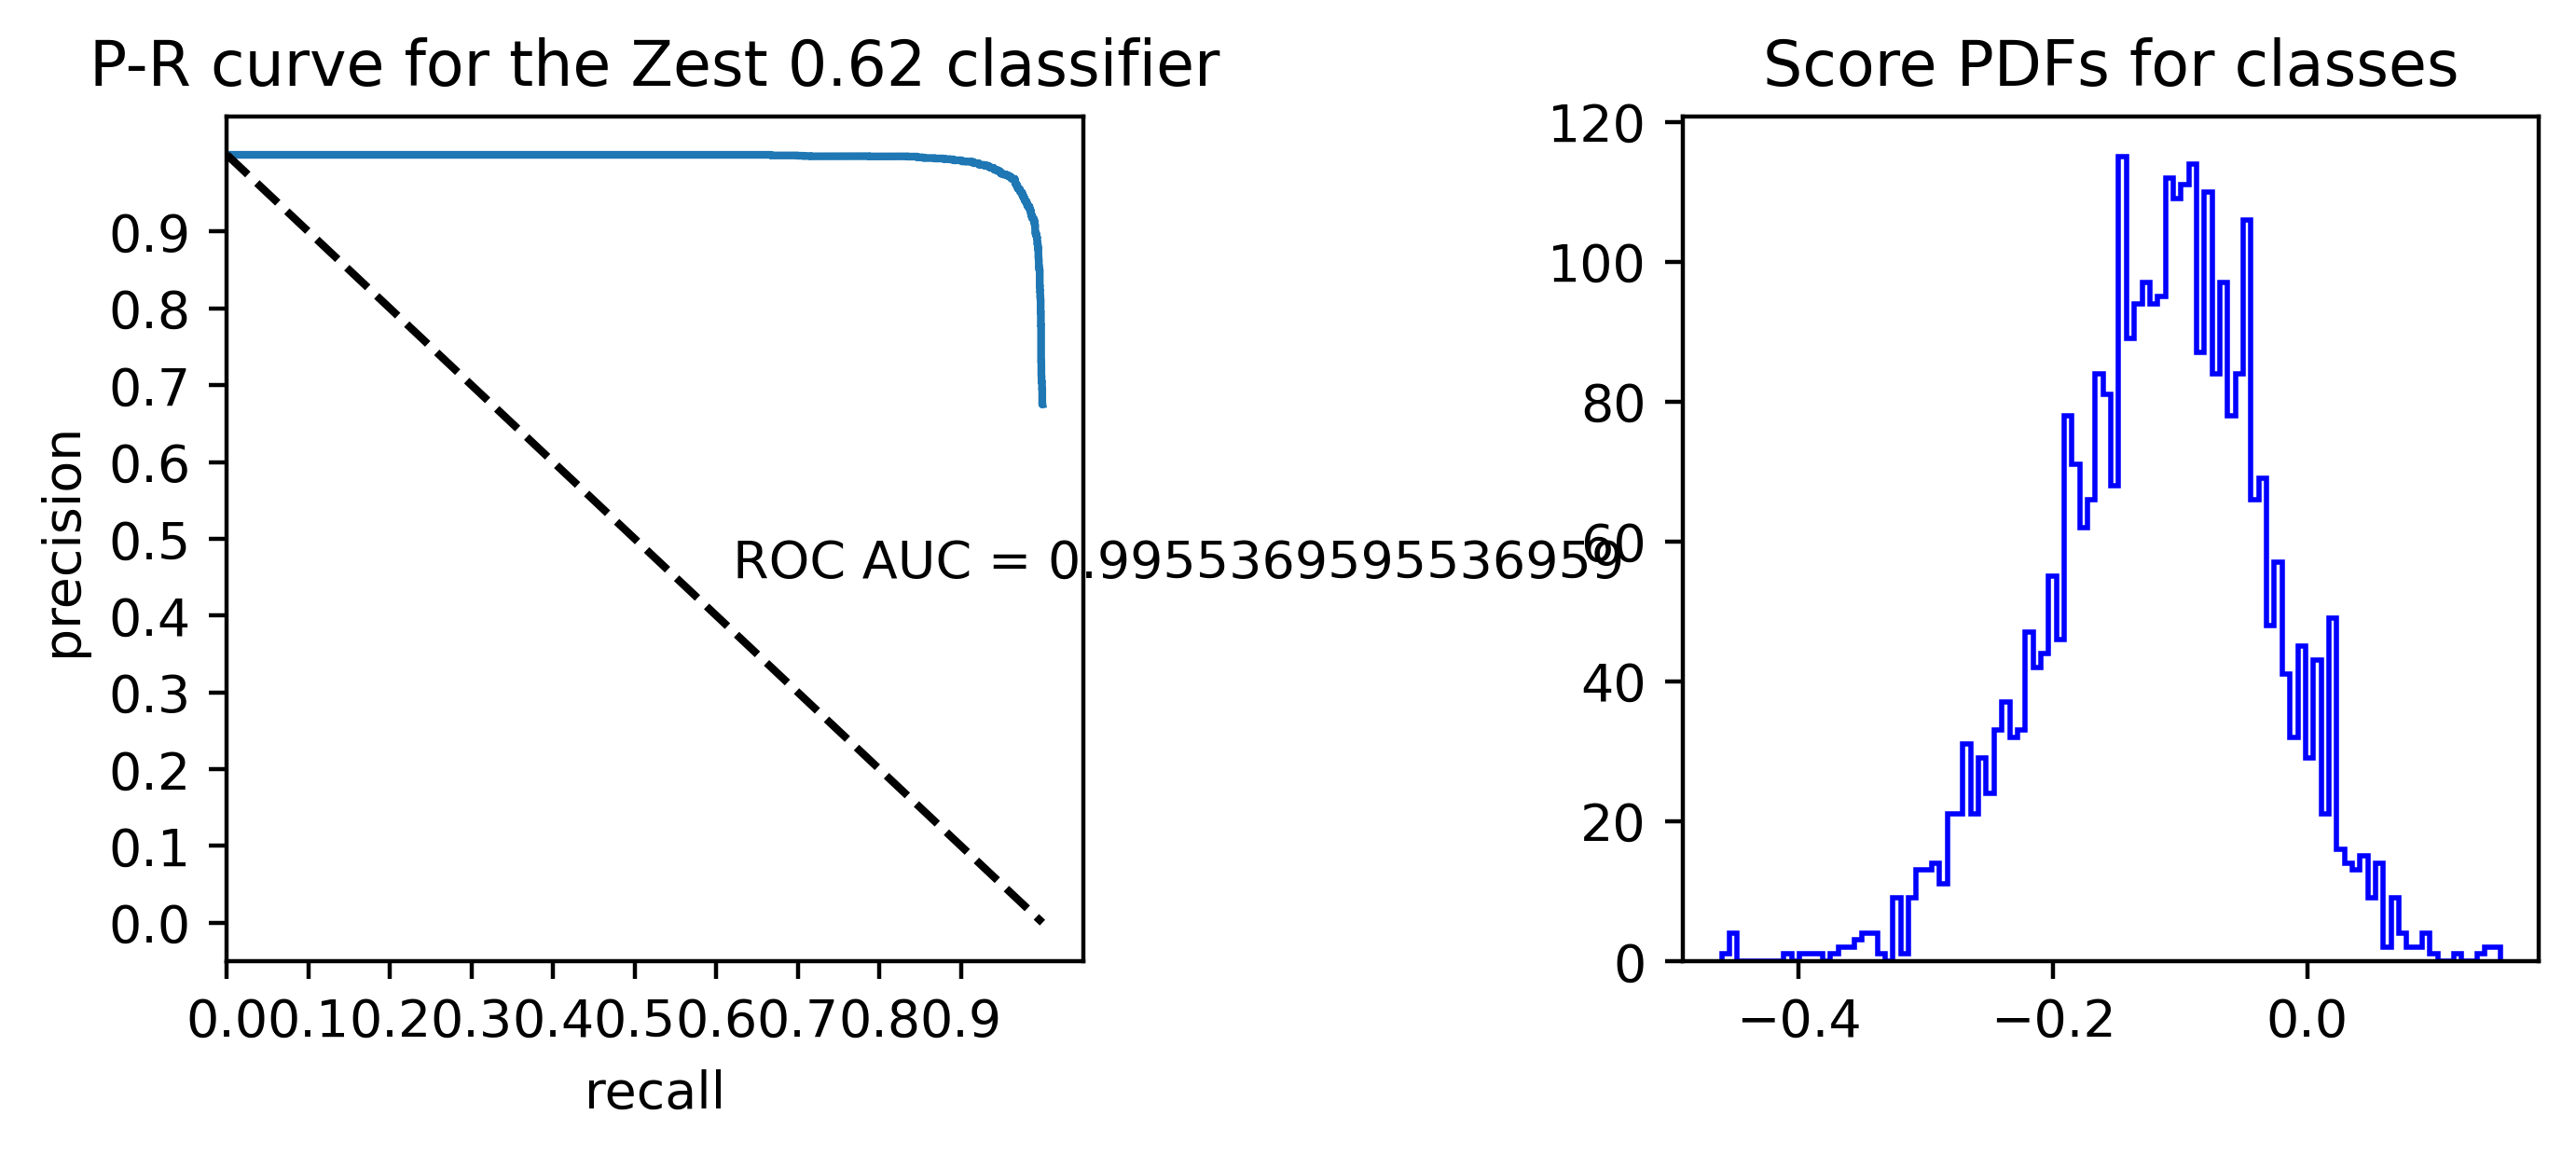

In [13]:
try:
    plot_PRcurve_and_scorePDF(scores_pos, scores_neg)
except AttributeError:
    print("")

In [14]:
def scatter_zstd_ratios(neg_nr, neg_pr, pos_nr, pos_pr) :
    fig = plt.figure(dpi=600, figsize=(8, 8))
    
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title('Negative labels')
    ax1.set(xlabel='Negative rate')
    ax1.set(ylabel='Positive rate')
    # ax1.grid(b=None)
    ax1.set_xticks(np.arange(0, 1, step=0.1))
    ax1.set_yticks(np.arange(0, 1, step=0.1))
    ax1.scatter(neg_nr, neg_pr, s=1, marker='.', color='b', alpha=0.3)
    dots = np.linspace(0, 1, 60)
    ax1.scatter(dots, dots, s=5, marker='.', color='k')
    
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title('Positive labels')
    ax2.set(xlabel='Negative rate')
    ax2.set(ylabel='Positive rate')
    #ax2.grid(b=None)
    ax2.set_xticks(np.arange(0, 1, step=0.1))
    ax2.set_yticks(np.arange(0, 1, step=0.1))
    ax2.scatter(pos_nr, pos_pr, s=1, marker='.', color='r', alpha=0.3)
    ax2.scatter(dots, dots, s=1, marker='.', color='k')

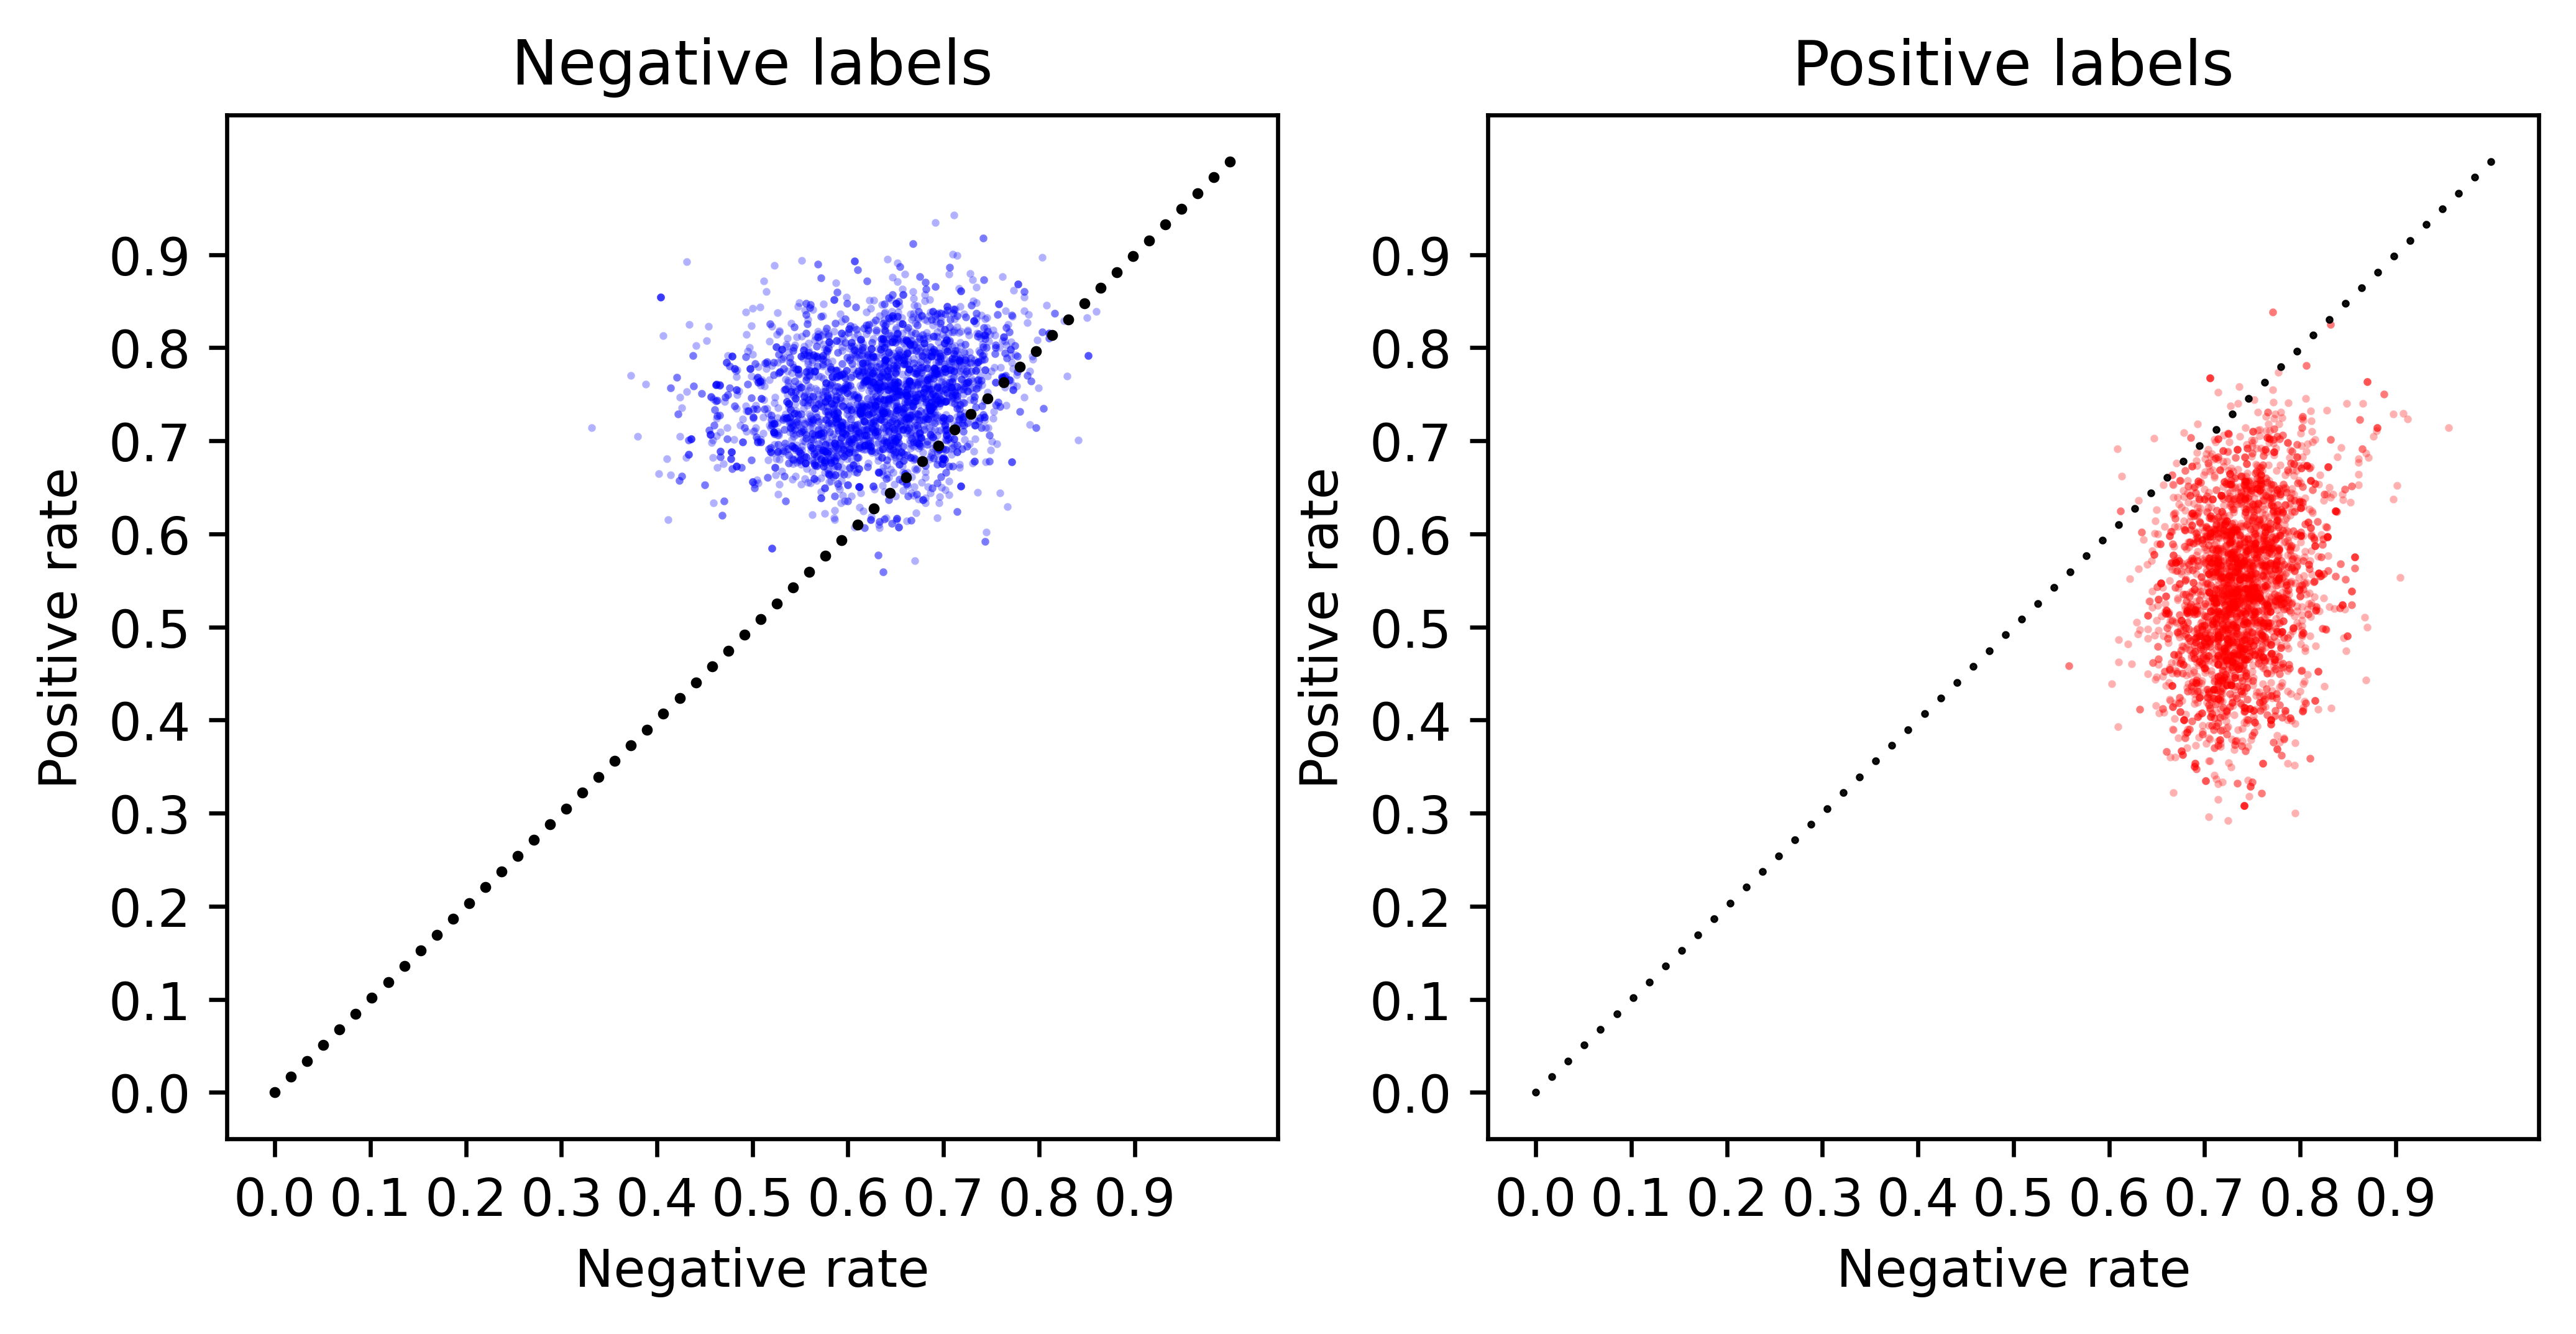

In [15]:
scatter_zstd_ratios(neg_nr, neg_pr, pos_nr, pos_pr)

## Compare with Hash N-Gram

In [16]:
class HashNGramClassifier:
    def __init__(
        self,
        name: str,
        pos_samples,
        neg_samples,
    ) -> None:

        self.hash_table_size: int = 2 * 3 * 5 * 7 * 11 * 13 * 17 + 1

        self.pos_tensor = np.zeros(
            [self.hash_table_size, 1]
        )
        self.neg_tensor = np.zeros(
            [self.hash_table_size, 1]
        )

        for sample in pos_samples:
            if sample is None:
                continue
            ngrams = self.generate_ngrams(sample, 3)
            for ngram in ngrams:
                sample_hash = int(hash(ngram) % self.hash_table_size)
                self.pos_tensor[sample_hash] += 1

        for sample in neg_samples:
            if sample is None:
                continue
            ngrams = self.generate_ngrams(sample, 3)
            for ngram in ngrams:
                sample_hash = int(hash(ngram) % self.hash_table_size)
                self.neg_tensor[sample_hash] += 1

    def generate_ngrams(self, s, n):
        if s is None:
            return []
        # Convert to lowercases
        s = s.lower()

        # Break sentence in the token, remove empty tokens
        tokens = []
        for token in s.split(" "):
            if token != "":
                tokens.append(token)

        # Concatentate the tokens into ngrams and return
        grams = []
        for i in range(n):
            grams.append(tokens[i:])
        ngrams = []
        for i in range(len(grams[n - 1])):
            curr_words = []
            for j in range(n):
                curr_words.append(grams[j][i])
            ngrams.append(" ".join(curr_words))
        return ngrams

    def score(self, s: str):
        curr_tensor = np.zeros([self.hash_table_size, 1])
        ngrams = self.generate_ngrams(s, 3)

        for ngram in ngrams:
            sample_hash = int(hash(ngram) % self.hash_table_size)
            curr_tensor[sample_hash] += 1

        pos_output = cosine_similarity(curr_tensor, self.pos_tensor)[0]
        neg_output = cosine_similarity(curr_tensor, self.neg_tensor)[0]

        return pos_output - neg_output

In [17]:
start_time = time.time()
cls_ngram = HashNGramClassifier('Clickbait', cb_pos, cb_neg)
print(f"N-Gram training time: {time.time() - start_time}")

N-Gram training time: 0.9088289737701416


Although training the n-gram doesn't take that long, running evaluation on the same amount of data crashes a Python 3 kernel. 

## Identify and diagnose scoring mistakes

In [18]:
print(*zip(scores_pos[-10:], cb_pos_eval[-10:]))

(0.12915851272015655, 'BuzzFeed Employees React To Twenty One Pilots Because Someone Asked Us To') (0.22539682539682548, '7 Easy Dinner Ideas To Try This Week') (0.20879120879120883, '11 Weird, Insane, And Absolutely Absurd Things I Learned From Grace Jones Memoir') (0.1673469387755102, 'Saturday Night Live Proved Adele Is The Only One Who Can Unite Us All') (0.1255411255411255, 'Life Without A Cat Vs Life With A Cat') (0.13320463320463316, 'Ring The Ol Cheating Alarm: Calvin Harris Was Spotted Leaving A Grocery Store') (0.22857142857142854, 'Which Version Of 1989 Should You Be Listening To') (0.27419354838709675, 'Heres What Happens When You Make Cookies With Potato Chips') (0.1104761904761905, '7 Essays To Read: Preventing Suicide, Crowdfunding Adoptions, And Being Single') (0.01279317697228155, 'Miss Piggy And Kermit Cant Have A Business Meeting Without Drama')


### Clickbait-positive titles scored negative

In [19]:
cb_pos_scores_off = scores_pos[cb_pos_off]
cb_pos_eval_off = cb_pos_eval[cb_pos_off]

idx_pos = np.argsort(cb_pos_scores_off)
prev_s = ""
seen_pos = set()
uniq_titles_pos = []

M = 45
j = 0
for i in idx_pos :
    if j > M : break
    title = cb_pos_eval_off[i]
    s = f"{cb_pos_scores_off[i]:.5} {title}"
    if prev_s != s :
        if title not in seen_pos :
            seen_pos.add(title)
            uniq_titles_pos.append(title)
            print(s)
            j += 1
    prev_s = s

-0.082707 Japanese Twitter Is Mocking Politicians After A Fight Broke Out In Parliament
-0.0625 Seven Years Later, Mumbaikars Recall The Horrific Events Of The 2611 Terrorist Attacks
-0.022133 23YearOld Student Dies of Suffocation During Skrillex Concert in Delhi
0.0068027 Watch A Weatherman Flawlessly Pronounce llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch
0.011628 Rory Williams Has Pretty Much Graduated From Companion To Doctor On Legends Of Tomorrow
0.016097 We Got Very Drunk At Work On Kingfishers New BreezerStyle Drink
0.017316 Rita Ora Wants To Remake Lady Marmalade And THAT IS NOT OK
0.024145 Sid The Beagle Is Running For Austin Mayor And He Means Business
0.02544 Aubrey Plaza Tried To Play With Robert De Niros Nipples But Did Not Succeed
0.043956 Country Star Jason Aldean Wore Blackface On Halloween To Dress Up As Lil Wayne
0.061508 I Got Fake Bangs To Inoculate Myself Against Actually Getting Bangs
0.087464 24 Times Toast The Dog Won Us Over In 2015


In [20]:
def explain(text : str) :
    score, comment, nr, pr = cb_score(text)
    print(f"{score:.4} ({nr:.4}, {pr:.4}) [{comment}] {text} ")
    scores = []
    t = sn.normalize_str(text)
    words = t.split()
    if len(words) < 2 : return
    for j, _ in enumerate(words) :
        words0 = deepcopy(words)
        del words0[j]
        test0 = " ".join(words0)
        sc, _, _, _ = cb_score(test0)
        print(f"{sc:.3} {words[j]}", end=" ")
    print()

### Clickbait-negative titles scored positive

In [21]:
cb_neg_scores_off = scores_neg[cb_neg_off]
cb_neg_eval_off = cb_neg_eval[cb_neg_off]

idx_neg = np.flip(np.argsort(cb_neg_scores_off))
prev_s = ""
seen_neg = set()
uniq_titles_neg = []

M = 25
j = 0
for i in idx_neg :
    if j > M : break
    title = cb_neg_eval_off[i]
    s = f"{cb_neg_scores_off[i]:.4} {title}"
    if prev_s != s :
        if title not in seen_neg :
            seen_neg.add(title)
            uniq_titles_neg.append(title)
            print(s)
            j += 1
    prev_s = s

0.1516 Mets Show More Reasons for Their Optimism
0.1376 Amazon Rights Error After TweetRage on Twitter
0.09429 Golf Shoes to Improve Your Style, and Your Game
0.07738 Federer Struggles With His Altered World
0.04945 Heartbreaking Triage as Fargo Battles Floods
0.04167 Paula Creamer Is Feeling Better and Aiming to Win on L.P.G.A. Tour
0.03571 Do Online Universities Have Virtual Cheerleaders?
0.03516 As The Boston Globe Quietly Struggled, Confusion Prevailed
0.02156 Special Skill Gives Steeler a Moment to Savor
0.02116 N.F.L. Stars Who Took the Pitch and Ran With It
0.01786 MLB: Tom Glavine wins 300th game
-0.01166 How ABC Interview Shaped a Torture Debate
-0.01329 UBS sees net income jump 15 percent
-0.07018 FIFA to make changes after Thierry Henry handball


## MC Language Model

In [22]:
def strhash(s):  # note that hash() produces different values upon every run
    sum = 13
    for c in s:
        sum += ((512927377 * sum + 19) ^ (ord(c) * 1001001 + 1301))
    return sum

In [23]:
def zipngram(text, n=2):
    return zip(*[list(text)[i:] for i in range(n)])

In [24]:
class MChainLangModel:
    # the input is assumed to be preprocessed (normalized, etc)

    verbose = 1
    version = 10 # 10 for 0.1
    remove_stray_chars = True

    def __init__(self,
                 name: str,
                 corpus: list,
                 counts_size: int = 10**7,
                 max_samples: int = 50000,
                 DF_thresh: float = 0.005):
        self.name = name
        self.num_samples = min(max_samples, len(corpus))
        self.DF_thresh = DF_thresh
        self.stray_chars = re.compile('[^\w\d .,:;¿?¡!_*+/|#]+')

        self.populate_char_ctrs(corpus[:max_samples], DF_thresh)

        prob = self.compute_total_char_prob()
        if prob < 0.9999:
            print("WARNING: MChainLangModel, total probability is", prob,
                  "(should be 1.0)")

        self.populate_bichar_ctrs(corpus[:max_samples])

        self.counts = np.zeros(counts_size, dtype=int)

        self.populate_higher_counts(corpus[:max_samples])

    def __str__(self):
        utilization = self.nonzeros / len(self.counts)
        return f"\n *** MChainLangModel vfor *{self.name}* based on {self.num_samples} samples"\
        f" and {self.num_chars} characters" \
        f"\n {len(self.ctr_df)} frequent chars, {len(self.leftover_chars)} leftover chars, "\
        f"{self.num_bi} character bigrams, {self.nonzeros} higher ngram ({100 * utilization:.4}% utilization)"\
        f"\nTop characters by DF with threshold {100 * self.DF_thresh:.3}% " \
        f"(blank + word characters):\n {self.ctr_df_trimmed}" \
        f"\nTop characters by occurrence:\n {self.ctr_occ_trimmed}"\
        f"\nLeftover characters: {self.leftover_chars}"\
        f"\nTop character bigrams: {self.ctr_bi_occ.most_common(20)}"\

    def cleanup0(self, s: str):
        s1 = re.sub(self.stray_chars, ' ',
                    s) if self.remove_stray_chars else ' '
        return re.sub('\s+', ' ', s1)

    def cleanup1(self, s: str):
        s1 = re.sub(self.rare_chars_regex, '', s)
        return re.sub('\s+', ' ', s1)

    def cleanup01(self, s: str):
        s1 = re.sub(self.stray_chars, ' ',
                    s) if self.remove_stray_chars else ' '
        s2 = re.sub(self.rare_chars_regex, '', s1)
        return re.sub('\s+', ' ', s2)

    def get_char_counts(self, corpus: list):
        ctr_df = Counter()
        ctr_occ = Counter()
        for t in corpus:
            tn = self.cleanup0(t)
            ctr_df += Counter(set(tn))
            ctr_occ += Counter(tn)
        return ctr_df, ctr_occ

    def populate_char_ctrs(self, corpus: list, DF_thresh: float):
        n = len(corpus)
        self.ctr_df, self.ctr_occ = self.get_char_counts(corpus)
        self.ctr_df_trimmed = Counter()
        self.ctr_occ_trimmed = Counter()
        self.unknown_char_occ = 0
        for chr, count in self.ctr_df.most_common(int(
                10 / DF_thresh)):  # limit characters to DF > 0.005
            occ = self.ctr_occ[chr]
            if count >= n * DF_thresh:
                self.ctr_df_trimmed[chr] = count
                self.ctr_occ_trimmed[chr] = occ
                self.min_occ = occ
            else:
                self.unknown_char_occ += occ
        self.num_chars = sum(self.ctr_occ.values())
        self.good_chars = ''.join([c for c in self.ctr_df_trimmed])
        self.leftover_chars = ''.join(
            [c for c in self.ctr_df - self.ctr_df_trimmed])
        self.rare_chars_regex = re.compile('[^' + self.good_chars + ']+')

    def compute_char_cross_entropy(self, s: str):
        # Compute X-entropy over all characters,
        # for rare characters assume half the lowest count
        if len(s) == 0: return 0.0
        sum_lp = 0
        for c in s:
            p = self.get_char_prob(c)
            sum_lp += math.log(p)
        return -sum_lp / len(s)

    def compute_char_cross_entropy1(self, s: str):
        # Compute X-entropy over good characters only
        s1 = self.remove_bad_chars(s)
        if len(s1) == 0: return 0.0
        sum_lp = 0
        for c in s1:
            p = self.get_char_prob(c)
            sum_lp += math.log(p)
        return -sum_lp / len(s1)

    def get_char_prob(self, c: str):
        count = self.ctr_occ_trimmed[c]
        if count == 0:
            count = self.unknown_char_occ
            if count == 0:
                count = self.min_occ / 2.0
        return count / self.num_chars

    def compute_total_char_prob(self):
        # This should be close to 1.0
        sum = 0.0
        for c in self.ctr_occ_trimmed:
            sum += self.get_char_prob(c)
        sum += self.get_char_prob('unknown')
        return sum

    def get_bichar_counts(self, corpus: list):
        ctr_bi_occ = Counter()
        num = 0
        for t in corpus:
            tn = self.cleanup01(t)
            if len(tn) < 2: next  # no bigrams
            tn_bigrams = [z[0] + z[1] for z in zipngram(tn, 2)]
            num += len(tn_bigrams)
            ctr_bi_occ += Counter(tn_bigrams)
        return ctr_bi_occ, num

    def populate_bichar_ctrs(self, corpus):
        self.ctr_bi_occ, self.num_bi = self.get_bichar_counts(corpus)
        #self.min_bi_occ = min(self.ctr_bi_occ.values())

    def get_bi_prob(self, bi):
        count = self.ctr_bi_occ[bi]
        if count > 0:
            return count / self.num_bi
        return self.get_char_prob(bi[0]) * self.get_char_prob(bi[1])

    def populate_higher_counts(self, corpus):
        for t in corpus:
            tn = self.cleanup01(t)
            l = len(t)
            if l < 3: next  # no trigrams
            for i in range(l - 2):
                for j in range(3, l - i):
                    idx = strhash(tn[i:j]) % len(self.counts)
                    self.counts[idx] += 1
                    if self.counts[idx] == 1: break  # similar to Kneser-Ney
        self.nonzeros = np.count_nonzero(self.counts)

    def compute_string_prob(self, s: str):
        s1 = self.cleanup01(s)
        return self.compute_string_prob_helper(s1)

    def compute_string_prob_helper(self, s: str):
        l = len(s)
        prob = 1.0
        i = 0
        while i < l:  # look for known substrings [i:j], the nested loop varies j
            # print(f"i={i}", prob)
            if l - i == 1:
                prob *= self.get_char_prob(s[i:])
                break
            if l - i == 2:
                prob *= self.get_bi_prob(s[i:])
                break
            # now we have at least three characters left

            bi_ct = self.ctr_bi_occ[s[i:i + 2]]
            if bi_ct == 0:  # bigram not found, so consume one character and try again
                # print(f"Bigram {s[i:i+2]} not found")
                prob *= self.get_char_prob(s[i])
                i += 1
                continue

            # bigram found, so compute ngram probability relative to the bigram probability
            prob *= bi_ct / self.num_bi  # multiply by additional probs later on
            # print(f"Bigram {s[i:i+2]} found", prob)

            prev_ct = bi_ct
            ct = 0
            for j in range(i + 3, l + 1):
                # print(f"{i}-{j}")
                idx = strhash(s[i:j]) % len(self.counts)
                ct = self.counts[idx] 
                if ct == 0:  # consume j - i characters, start a new substring at `j - 1`
                    i = j - 1
                    prob *= (prev_ct / bi_ct)
                    break
                else:  # extend the substring by one more char
                    # print("Ngram found", s[i:j])
                    prev_ct = ct
            if ct != 0:  # we must have exhausted `s`
                prob *= prev_ct / bi_ct
                break

        return prob

In [25]:
class MChainClassifier:
    # the input is assumed to be preprocessed (normalized, etc)

    verbose = 1
    version = 10 # 10 for 0.1

    def __init__(self, name: str, pos_samples: list, neg_samples: list):

        self.name = name
        if self.verbose > 0:
            print(
                f'Building a Markov-chain *{name}* classifier v{self.version/100} for {len(pos_samples)} positive and '
                f'{len(neg_samples)} negative samples')
        self.pos_model = MChainLangModel('positive', pos_samples)       
        self.neg_model = MChainLangModel('negative', neg_samples)
        self.neg_to_pos_ratio = len(neg_samples) / len(pos_samples)
        
    def __str__(self):
        return f'Markov-Chain *{self.name}* classifier v{self.version/100}'\
            + str(self.pos_model) + str(self.neg_model)

    def score(self, s: str):
        # 0.0 for the negative class, 1.0 for the positive class
        # Normalization must be performed before this call
        neg_pr = self.neg_model.compute_string_prob(s)
        pos_pr = self.pos_model.compute_string_prob(s)
        denom = 1 + (neg_pr / pos_pr) * self.neg_to_pos_ratio 
        return 1 / denom

In [26]:
start_time = time.time()
mc_cls = MChainClassifier('Clickbait', cb_pos, cb_neg)
print(f"MC training time: {time.time() - start_time}")

Building a Markov-chain *Clickbait* classifier v0.1 for 15999 positive and 16001 negative samples
MC training time: 38.61919689178467


In [27]:
scores_pos=np.zeros(len(cb_pos_eval))
scores_neg=np.zeros(len(cb_neg_eval))

In [28]:
start_time = time.time()
sum_pos = 0
num_pos_zeros = 0
for i, t in enumerate(cb_pos_eval):
    t1 = cleanup_str(t, sn, char_ctr)
    sc = mc_cls.score(t1)
    if sc == 0.0 :
        num_pos_zeros += 1
        #print(f"{i}. {sc} {comment} {t}")
    scores_pos[i] = sc
    sum_pos += sc
    
print(f"=== {100 * num_pos_zeros / i:.4} % zero scores among positive examples")

sum_neg = 0
num_neg_zeros = 0
for i, t in enumerate(cb_neg_eval):
    t1 = cleanup_str(t, sn, char_ctr)
    sc = mc_cls.score(t1)
    if sc == 0.0 :
        num_neg_zeros +=1 
        #print(f"{i}. {comment} {sc} {nr:.4} {pr:.4} {comment} {t}")
    scores_neg[i] = sc
    sum_neg += sc

    
print(f"=== {100 * num_neg_zeros / i:.4} % zero scores among negative examples\n")
    
print(f"Avg scores for CB = {sum_pos/len(cb_pos_eval):.4}, non-CB = {sum_neg/len(cb_neg_eval):.4}")

print(f"MC testing time: {time.time() - start_time}")

=== 0.0 % zero scores among positive examples
=== 0.0 % zero scores among negative examples

Avg scores for CB = 0.9943, non-CB = 0.03242
MC testing time: 2.058500051498413


In [29]:
k = N
num_corr = 0

cb_pos_off = []
cb_neg_off = []

num_eq = 0
for j in range(k) :
    i_pos = random.randint(0, len(scores_pos) - 1)
    i_neg = random.randint(0, len(scores_neg) - 1)
    if scores_pos[i_pos] > scores_neg[i_neg] :
        num_corr += 1
    elif scores_pos[i_pos] == scores_neg[i_neg] :
        num_corr += 0.5
        num_eq += 1
    else :
        cb_pos_off.append(i_pos)
        cb_neg_off.append(i_neg)
        
AUC = num_corr / k
AUC_line = f"ROC AUC = {AUC}"
print(AUC_line)
print("Num eq =", num_eq)

ROC AUC = 0.999163179916318
Num eq = 0


	 P@r50 = 0.979  score=0.999 		  R@p50 = 1.0  score=-0.0647
	 P@r60 = 0.977  score=0.9337 		  R@p60 = 0.997  score=9.779e-23



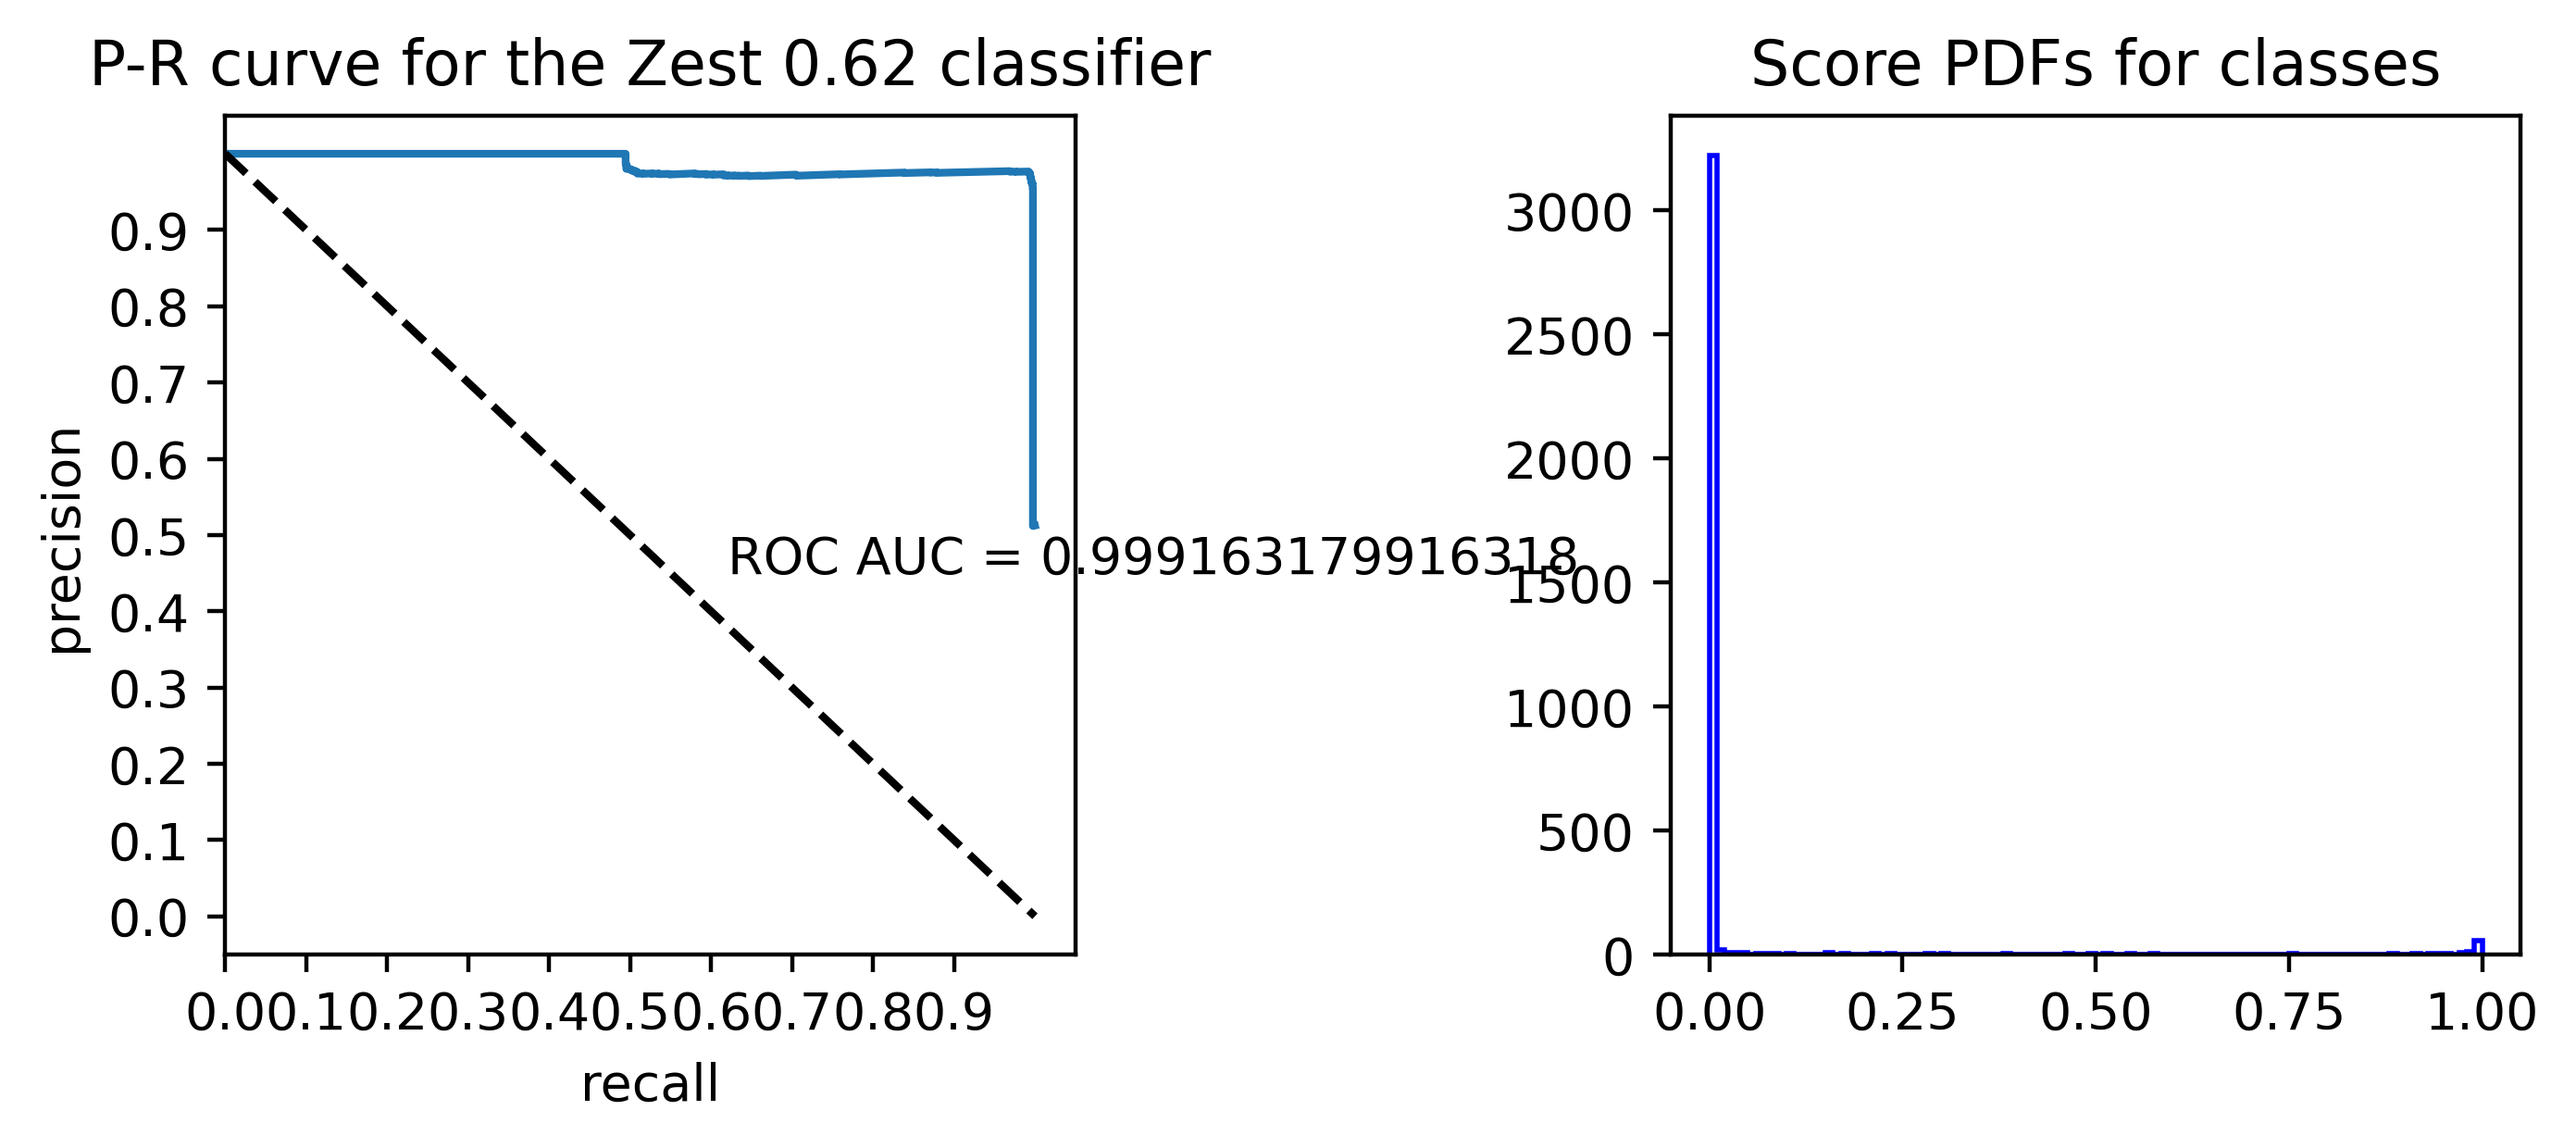

In [30]:
try:
    plot_PRcurve_and_scorePDF(scores_pos, scores_neg)
except AttributeError:
    print("")